In [403]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.dummy import DummyRegressor
import warnings

In [404]:
data_df = pd.read_csv('house-prices.csv')
print(data_df.shape)
data_df.head()

(2430, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


# Data cleaning

In [405]:
## Having a look at the data
random.seed(65615)
r = int(random.random()*len(data_df))
for i in data_df.columns:
    print(data_df[i].dtype, '\n', i, '\t', data_df[i][0], '\n\t\t', data_df[i][r])

int64 
 Order 	 484 
		 1093
int64 
 PID 	 528275070 
		 528280130
int64 
 MS SubClass 	 60 
		 60
object 
 MS Zoning 	 RL 
		 RL
float64 
 Lot Frontage 	 nan 
		 93.0
int64 
 Lot Area 	 8795 
		 10261
object 
 Street 	 Pave 
		 Pave
object 
 Alley 	 nan 
		 nan
object 
 Lot Shape 	 IR1 
		 IR1
object 
 Land Contour 	 Lvl 
		 Lvl
object 
 Utilities 	 AllPub 
		 AllPub
object 
 Lot Config 	 Inside 
		 Inside
object 
 Land Slope 	 Gtl 
		 Gtl
object 
 Neighborhood 	 Gilbert 
		 Gilbert
object 
 Condition 1 	 Norm 
		 Norm
object 
 Condition 2 	 Norm 
		 Norm
object 
 Bldg Type 	 1Fam 
		 1Fam
object 
 House Style 	 2Story 
		 2Story
int64 
 Overall Qual 	 7 
		 6
int64 
 Overall Cond 	 5 
		 5
int64 
 Year Built 	 2000 
		 2000
int64 
 Year Remod/Add 	 2000 
		 2000
object 
 Roof Style 	 Gable 
		 Gable
object 
 Roof Matl 	 CompShg 
		 CompShg
object 
 Exterior 1st 	 VinylSd 
		 VinylSd
object 
 Exterior 2nd 	 VinylSd 
		 VinylSd
object 
 Mas Vnr Type 	 None 
		 BrkFace
float64 
 Mas Vnr

In [406]:
##no duplicates, as expected
data_df.duplicated().sum()

0

In [407]:
### checking empty values
print('Number of columns with empty value: ', len(data_df.isnull().sum()[data_df.isnull().sum() > 0]))
data_df.isnull().sum()[data_df.isnull().sum() > 0]

Number of columns with empty value:  27


Lot Frontage       420
Alley             2267
Mas Vnr Type        20
Mas Vnr Area        20
Bsmt Qual           71
Bsmt Cond           71
Bsmt Exposure       74
BsmtFin Type 1      71
BsmtFin SF 1         1
BsmtFin Type 2      72
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1186
Garage Type        136
Garage Yr Blt      138
Garage Finish      138
Garage Cars          1
Garage Area          1
Garage Qual        138
Garage Cond        138
Pool QC           2418
Fence             1941
Misc Feature      2340
dtype: int64

From the documentation, we see that for most of the variables, NA is a category, showing absence of a feature. Nonetheless, we want to check that the missing value for broad categories (basements and garage, namely) are consistent across the sub-variables. 

Then, we will think of removing variables with too much data missing. 

### Missing data consistency

#### Basements

In [408]:
### Bsmt Exposure has more NaNs than the other Bsmt variables, we investigate
### we see that the 3 rows are unfinished basement.
data_df[data_df['Bsmt Exposure'].isnull()].loc[~data_df['BsmtFin Type 1'].isnull(), 
                                               ['Bsmt Qual', 'Bsmt Cond',
                                                'Bsmt Exposure', 'BsmtFin Type 1',
                                                'BsmtFin SF 1', 'BsmtFin Type 2',
                                                'BsmtFin SF 2','Bsmt Unf SF', 'Total Bsmt SF']]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
875,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0
1681,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0
1726,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0


In [409]:
### the rows correspond to unfinished basements
### we see that Bsmt Exposure in our 3 rows should be 'No'
### we change the values accordingly
data_df.loc[data_df['BsmtFin Type 1']=='Unf', ['Bsmt Qual', 'Bsmt Cond',
                                                'Bsmt Exposure', 'BsmtFin Type 1',
                                                'BsmtFin SF 1', 'BsmtFin Type 2',
                                                'BsmtFin SF 2','Bsmt Unf SF', 'Total Bsmt SF']].head()

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
1,TA,TA,No,Unf,0.0,Unf,0.0,216.0,216.0
2,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0
4,TA,TA,No,Unf,0.0,Unf,0.0,925.0,925.0
5,TA,TA,No,Unf,0.0,Unf,0.0,747.0,747.0
6,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0


In [410]:
data_df.loc[[875, 1681, 1726],'Bsmt Exposure'] = 'No'

In [411]:
### we have an issue with an extra NaN in BSMTFin Type 2 and BsmtFin SF 1, SF 2, Unf SF, and Total Bsmt SF 
### obs 104 has discrepancies. Changing it rows accordingly should do the trick
data_df.loc[data_df['BsmtFin SF 1'].isnull(), ['Bsmt Qual', 'Bsmt Cond','Bsmt Exposure', 'BsmtFin Type 1',
                                           'BsmtFin SF 1', 'BsmtFin Type 2',
                                           'BsmtFin SF 2','Bsmt Unf SF', 'Total Bsmt SF']]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [412]:
data_df.loc[104, ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']] = 0

In [413]:
### we have an issue with a BsmtFin Type 2 
### we assume that BsmtFin 2 for obs 602 should be Unf as there is unfinished surface reported
### we change the value accordingly
data_df.loc[data_df['BsmtFin Type 2'].isnull(), :].loc[~data_df['Bsmt Qual'].isnull(), ['Bsmt Qual', 'Bsmt Cond','Bsmt Exposure', 'BsmtFin Type 1',
             'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2','Bsmt Unf SF',
             'Total Bsmt SF']]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
602,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0


In [414]:
data_df.loc[602, 'BsmtFin Type 2'] = 'Unf'

In [415]:
### chasing the lone Nans
### For electrical, we chose the most common value (SBrkr) as the placeholder
### The rest should be 0.0
data_df.loc[(data_df['Electrical'].isnull() | data_df['Bsmt Full Bath'].isnull() | 
            data_df['Bsmt Half Bath'].isnull() | data_df['Garage Cars'].isnull() |
            data_df['Garage Area'].isnull()), 
            ['Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars', 'Garage Area']]

,Electrical,Bsmt Full Bath,Bsmt Half Bath,Garage Cars,Garage Area
104,FuseA,NaN,NaN,1.0,280.0
694,NaN,0.0,0.0,2.0,400.0
1565,SBrkr,0.0,0.0,NaN,NaN
2056,SBrkr,NaN,NaN,2.0,624.0


In [416]:
data_df['Electrical'].value_counts()

SBrkr    2223
FuseA     160
FuseF      38
FuseP       7
Mix         1
Name: Electrical, dtype: int64

In [417]:
data_df.loc[[104, 2056], ['Bsmt Full Bath', 'Bsmt Half Bath']] = 0

In [418]:
data_df.loc[694, 'Electrical'] = 'SBrkr'

In [419]:
data_df.loc[1565, ['Garage Cars', 'Garage Area']] = 0

In [420]:
data_df.isnull().sum()[data_df.isnull().sum() > 0]

Lot Frontage       420
Alley             2267
Mas Vnr Type        20
Mas Vnr Area        20
Bsmt Qual           71
Bsmt Cond           71
Bsmt Exposure       71
BsmtFin Type 1      71
BsmtFin Type 2      71
Fireplace Qu      1186
Garage Type        136
Garage Yr Blt      138
Garage Finish      138
Garage Qual        138
Garage Cond        138
Pool QC           2418
Fence             1941
Misc Feature      2340
dtype: int64

### Garage variables

In [421]:
### we have 2 NaN values less in Garage Type than in the other variables
### 
data_df.loc[data_df['Garage Yr Blt'].isnull(), ['Garage Type', 'Garage Yr Blt', 
                                                'Garage Finish','Garage Cars', 
                                                'Garage Area', 'Garage Qual',
                                               'Garage Cond']].loc[~data_df['Garage Type'].isnull(),:]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1114,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
1565,Detchd,NaN,NaN,0.0,0.0,NaN,NaN


In [422]:
### we decide to use the Year remod/add as proxy for the year the garage were built 
### as we are not not sure whether garages were common in the 1910-20s' Iowa...
### especially as they are detached (hence probably not built at the same time as the house/building)
### we consider them 2 finished regarding the time elapsed between estimated build and data collection
data_df.loc[[1114, 1565], ['Year Built', 'Year Remod/Add']]

,Year Built,Year Remod/Add
1114,1910,1983
1565,1923,1999


In [423]:
### we take Typical/Average category as the default value for Garage Quality and Condition
data_df['Garage Qual'].value_counts()

TA    2156
Fa     109
Gd      20
Po       5
Ex       2
Name: Garage Qual, dtype: int64

In [424]:
### we take Unf as the default category for the two obs missing
data_df['Garage Finish'].value_counts()

Unf    1031
RFn     665
Fin     596
Name: Garage Finish, dtype: int64

In [425]:
data_df['Garage Cond'].value_counts()

TA    2202
Fa      61
Po      14
Gd      13
Ex       2
Name: Garage Cond, dtype: int64

In [426]:
data_df.loc[[1114, 1565], ['Garage Yr Blt', 'Garage Finish']] = [['1983', 'Unf'], ['1999', 'Unf']]

In [427]:
data_df.loc[[1114, 1565], ['Garage Yr Blt', 'Garage Finish']]

,Garage Yr Blt,Garage Finish
1114,1983,Unf
1565,1999,Unf


In [428]:
data_df.loc[[1114, 1565], ['Garage Qual', 'Garage Cond']] = [['TA', 'TA'], ['TA', 'TA']]

In [429]:
### for most of our Nan values, NaN conveys the info of the absence of a feature
### still, we have NaN were there shouldn't be
### let's see

### Lot Frontage missing values 
### considering that the minimum is at 21 feet
### we assume that NaNs means that properties are not connected to street (like access through courtyard or so)
### hence value is 0
data_df.loc[data_df['Lot Frontage'].isnull(), 'Lot Frontage'] = 0

In [430]:
### Masonry veneer
### having a look at the data, we first assume that there's a link between the exterior material 
### and the masonry, with 16/20 Vinyl exteriors
data_df.loc[data_df['Mas Vnr Type'].isnull(), 'Exterior 1st'].value_counts()

VinylSd    16
CemntBd     2
Wd Sdng     1
WdShing     1
Name: Exterior 1st, dtype: int64

In [431]:
### we see that 'None' is the max class for each of our 4 types of exterirors 
### present in ou Mas Vnr Type isnull() set. Then, 0 is the Mas Area.
### we change the values accordingly
data_df.groupby(by=['Exterior 1st', 'Mas Vnr Type']).count()['PID'].loc[['VinylSd', 'CemntBd', 'WdShing', 
                                                                         'Wd Sdng'], :]

Exterior 1st  Mas Vnr Type
CemntBd       BrkFace          19
              None             47
              Stone            24
VinylSd       BrkCmn            2
              BrkFace         295
              None            405
              Stone           140
Wd Sdng       BrkCmn            6
              BrkFace          58
              None            270
              Stone             7
WdShing       BrkCmn            2
              BrkFace          10
              None             33
              Stone             1
Name: PID, dtype: int64

In [432]:
data_df.loc[data_df['Mas Vnr Type'].isnull(), 'Mas Vnr Type'] = 'None'

In [433]:
data_df.loc[data_df['Mas Vnr Area'].isnull(), 'Mas Vnr Area'] = 0

In [434]:
### we see that we are left with only ordinal/ category variable
### for which no data is an information
### except for the Garage yerar building though
print('Number of columns with empty value: ', len(data_df.isnull().sum()[data_df.isnull().sum() > 0]))
data_df.isnull().sum()[data_df.isnull().sum() > 0]

Number of columns with empty value:  15


Alley             2267
Bsmt Qual           71
Bsmt Cond           71
Bsmt Exposure       71
BsmtFin Type 1      71
BsmtFin Type 2      71
Fireplace Qu      1186
Garage Type        136
Garage Yr Blt      136
Garage Finish      136
Garage Qual        136
Garage Cond        136
Pool QC           2418
Fence             1941
Misc Feature      2340
dtype: int64

### Removing variables with too much information missing & outliers

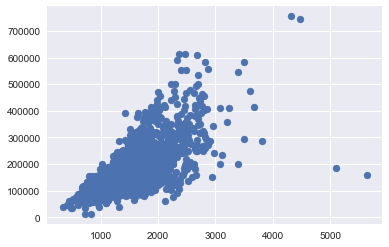

In [435]:
## Following the documentation, we look at the outliers based on GR Liv Area to Sales Price
## according to the doc, we should have 5 observaitons > 4000, but we have only 4. 
### we remove them 4 from our dataset 
plt.scatter(data_df['Gr Liv Area'], data_df.SalePrice)
plt.show()

In [436]:
data_df = data_df[data_df['Gr Liv Area'] < 4000]

In [437]:
data_df.shape

(2426, 82)

In [438]:
## looking for columns with more than 95% of missing data 
data_df.isnull().sum()[data_df.isnull().sum() > 2430 *.95]

Pool QC         2416
Misc Feature    2337
dtype: int64

In [439]:
### we only have 10 obs left with a pool
(data_df['Pool Area'] != 0).sum()

10

In [440]:
### that's 0.4% of our data, we remove it, and same for Misc. Features
### and for Misc Value and Pool Area as well
data_df.drop(['Misc Val', 'Misc Feature', 'Pool Area'], axis=1, inplace=True)

In [441]:
data_df.drop(['Pool QC'], axis=1, inplace=True)

In [442]:
### we check whether we have other outliers in continous data
cont_var = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
           'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 
           'Low Qual Fin SF', 'Garage Area', 'Wood Deck SF', 'Enclosed Porch']

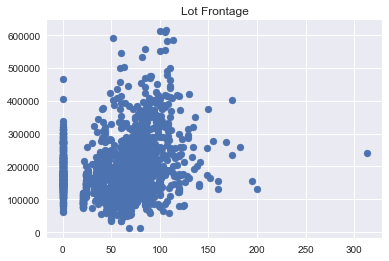

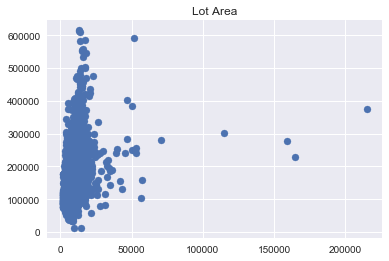

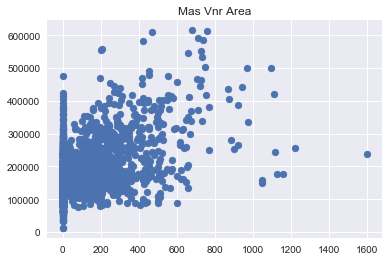

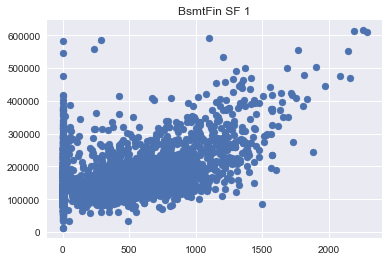

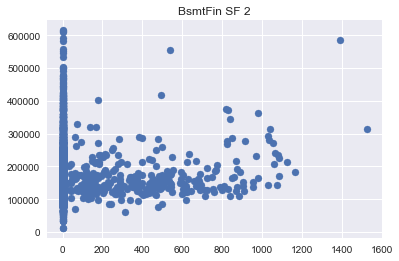

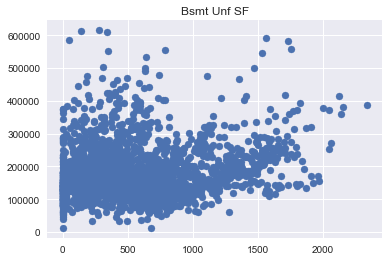

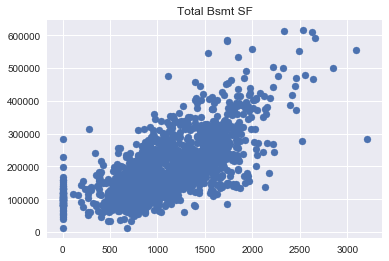

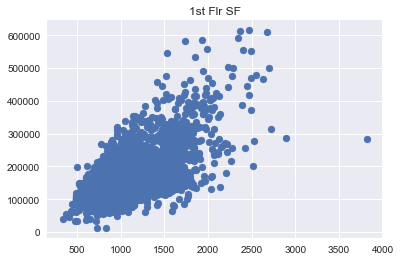

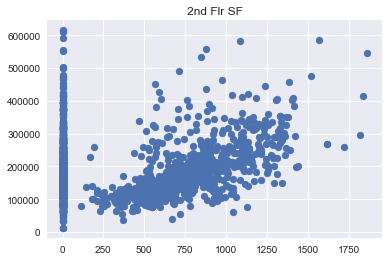

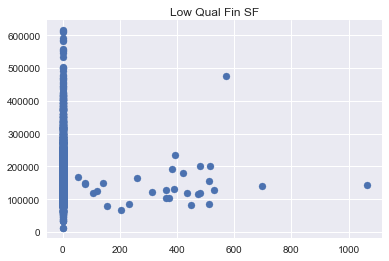

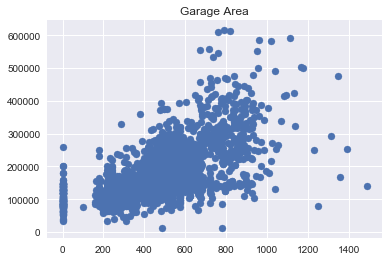

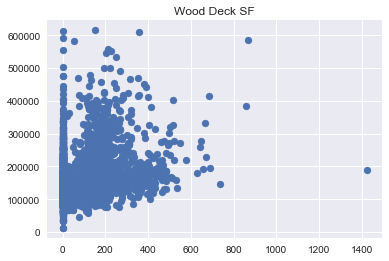

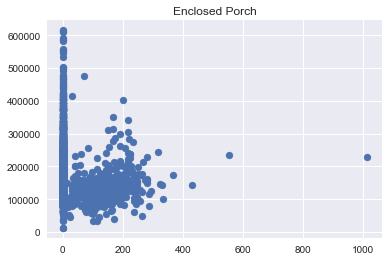

In [443]:
for i in cont_var:
    plt.scatter(data_df[i], data_df['SalePrice'])
    plt.title(i)
    plt.show()

In [444]:
nrows = data_df.shape[0]
for i in cont_var:
    st_dev = data_df[i].std()
    outliers = (np.abs(data_df[i] - data_df[i].mean()) > 2.58 * st_dev).sum()
    print(i, ' has ', outliers, ' outliers, ', '{:.2f}%'.format(outliers/nrows*100), ' of the data.')

Lot Frontage  has  14  outliers,  0.58%  of the data.
Lot Area  has  27  outliers,  1.11%  of the data.
Mas Vnr Area  has  69  outliers,  2.84%  of the data.
BsmtFin SF 1  has  32  outliers,  1.32%  of the data.
BsmtFin SF 2  has  99  outliers,  4.08%  of the data.
Bsmt Unf SF  has  41  outliers,  1.69%  of the data.
Total Bsmt SF  has  27  outliers,  1.11%  of the data.
1st Flr SF  has  35  outliers,  1.44%  of the data.
2nd Flr SF  has  14  outliers,  0.58%  of the data.
Low Qual Fin SF  has  25  outliers,  1.03%  of the data.
Garage Area  has  20  outliers,  0.82%  of the data.
Wood Deck SF  has  58  outliers,  2.39%  of the data.
Enclosed Porch  has  106  outliers,  4.37%  of the data.


Problem: the absence/presence nature of most of the data seriously skews the distributions: the 2.58 standard deviation threshold is the 99% confidence interval, but we see that we have up to 4.37% of the data over it depending on the variable. 

We decide then to use the graphical analysis to define our outliers, and proceed to remove them. 

In [445]:
data_df.shape

(2426, 78)

In [446]:
### Most of the outliers might be the same observation, but, well.. 
### I'll check that in another life or if requested.  
data_df = data_df[data_df['Lot Frontage'] < 185]
data_df = data_df[data_df['Lot Area'] < 70000]
data_df = data_df[data_df['Mas Vnr Area'] < 1200]
data_df = data_df[data_df['BsmtFin SF 2'] < 1350]
data_df = data_df[data_df['Bsmt Unf SF'] < 2300]
data_df = data_df[data_df['1st Flr SF'] < 3500]
data_df = data_df[data_df['Low Qual Fin SF'] < 550]
data_df = data_df[data_df['Wood Deck SF'] < 1200]
data_df = data_df[data_df['Enclosed Porch'] < 400]

In [447]:
data_df.shape

(2406, 78)

We removed 20 observations. We check our distributions to make sure everything's fine. 

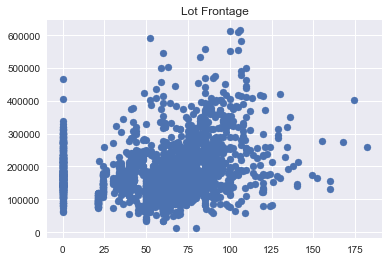

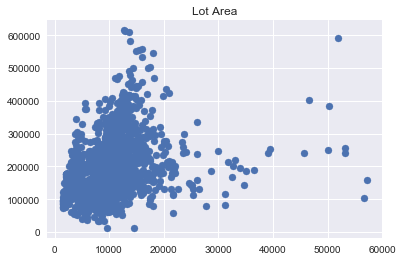

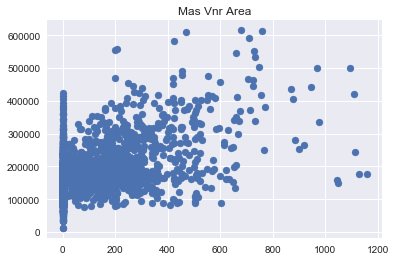

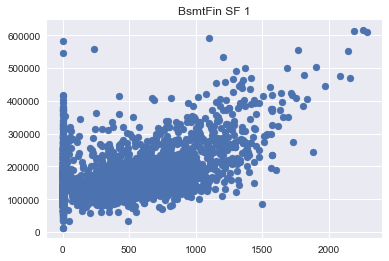

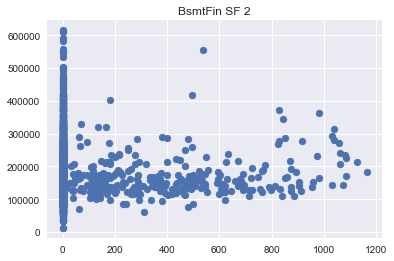

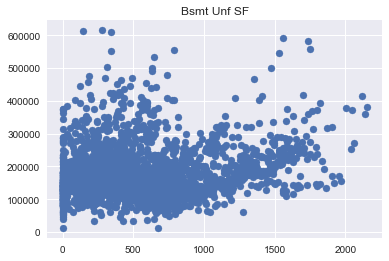

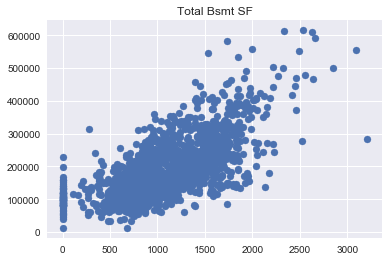

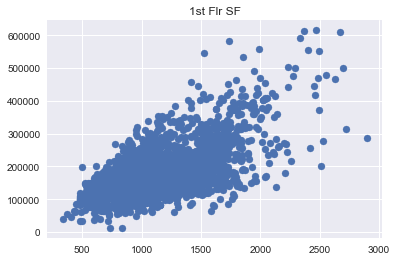

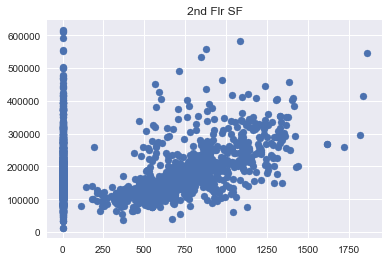

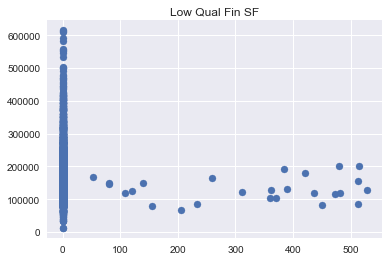

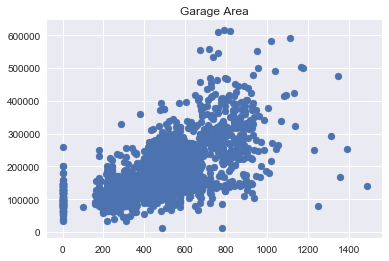

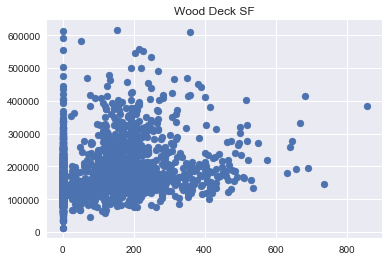

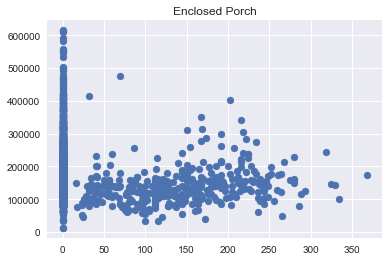

In [448]:
for i in cont_var:
    plt.scatter(data_df[i], data_df['SalePrice'])
    plt.title(i)
    plt.show()

Looking good. 

In [449]:
### not sure whether this is absolutely necessary/useful, but let's take a couple of minutes to do so in case. 

### listing ordinal values
ord_values = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 
              'Exter Cond', 'Bsmt Qual',
             'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 
             'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond',
             'Paved Drive', 'Fence']

### listing nominal values 
nom_values = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Utilities', 'Lot Config',
             'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 
              'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 
             'Heating', 'Central Air', 'Garage Type', 'Sale Type', 'Sale Condition', ]

### listing discrete values
discr_values = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 
               'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
               'Garage Cars', 'Mo Sold', 'Yr Sold']

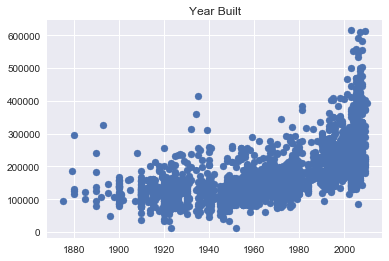

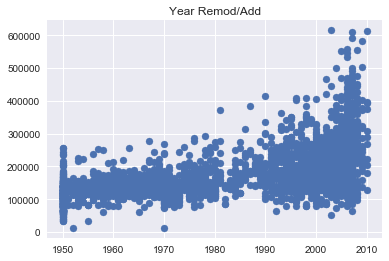

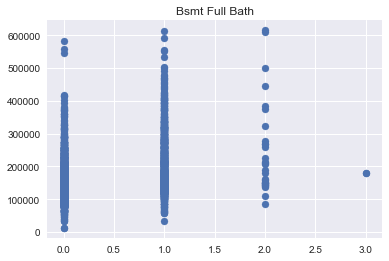

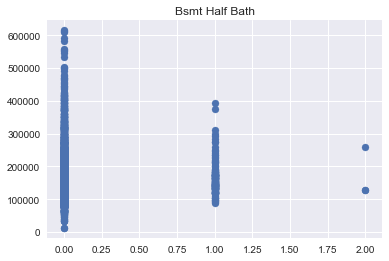

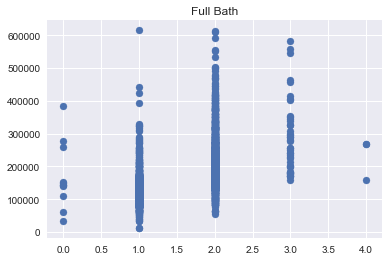

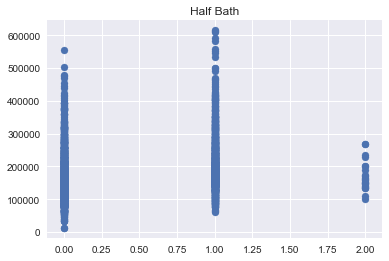

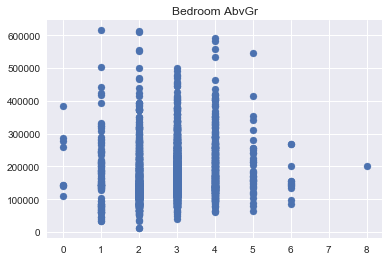

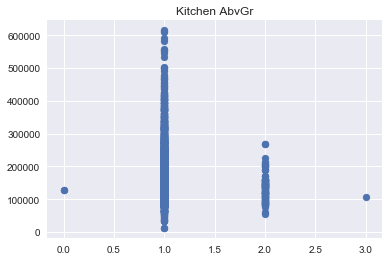

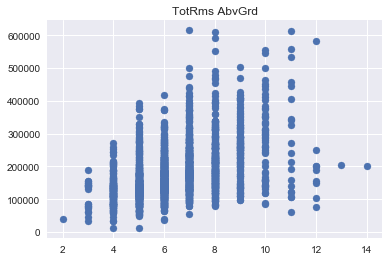

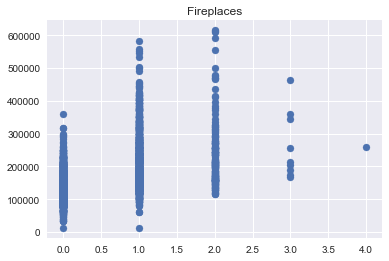

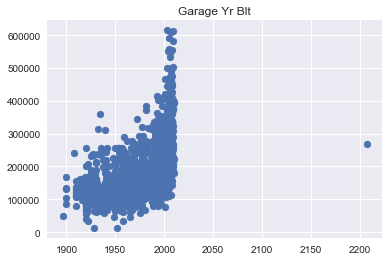

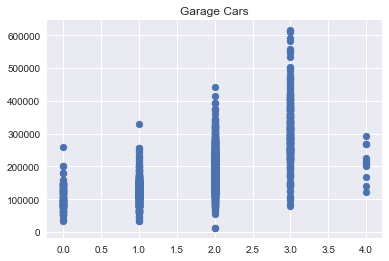

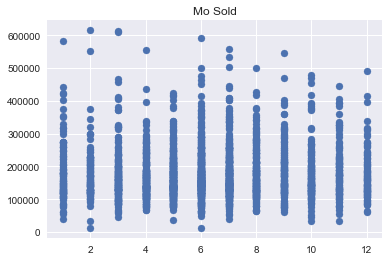

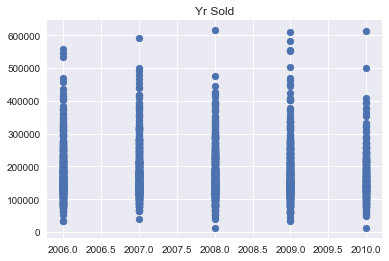

In [450]:
for i in discr_values:
    plt.scatter(data_df[i], data_df['SalePrice'])
    plt.title(i)
    plt.show()
    plt.close()

In [451]:
data_df.loc[data_df['Garage Yr Blt'] == 2207, 'Garage Type':'Garage Cond']

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
2219,Attchd,2207,RFn,2.0,502.0,TA,TA


In [452]:
## we assume a typo, with 2207 instead of 2007
## and change accordingly
data_df.loc[data_df['Garage Yr Blt'] == 2207,['Year Built', 'Year Remod/Add']]

,Year Built,Year Remod/Add
2219,2006,2007


In [453]:
data_df.loc[2219, 'Garage Yr Blt'] = 2007

# Misc. data modifying, Encoding, Feature Engineering

In [454]:
### we reindex on PID (needed for predicitons
### and delete the Order column
data_df.set_index('PID', inplace=True)
data_df.drop('Order', axis = 1, inplace=True)

### Encoding....

In [455]:
### there's an issue, it seems that one of my variables listed is not in the columns names
nom_values_exist = [elem in data_df.columns for elem in nom_values]
print([indx for i,indx in enumerate(nom_values) if not nom_values_exist[i]])

ord_values_exist = [elem in data_df.columns for elem in ord_values]
[indx for i,indx in enumerate(ord_values) if not ord_values_exist[i]]

###Modifying

[]


[]

In [456]:
### filling the Nas as a category
data_df.loc[:, nom_values + ord_values] = data_df.loc[:, nom_values + ord_values].fillna('NA')

We will one-hot encode the nominal values, and numerically order the ordinal categories, so as to reflect the difference between each class in our parameters values. 

In [457]:
### encoding ordered values with numerical values
### ... 
### idling a bit before doing anything
### ...
### Looking for motivation....
### ....
### Fatal Error
### ... 
### Restarting
### ...
### @chadmulligan: encoding --name ord_values execute
data_df['Lot Shape'] = pd.Categorical(data_df['Lot Shape'], categories=['Reg', 'IR1', 'IR2', 'IR3'][::-1], 
                                      ordered=True)
data_df['Utilities'] = pd.Categorical(data_df['Utilities'], 
                                      categories=['AllPub', 'NoSewr', 'NoSeWa', 'ELO'][::-1], ordered=True)
data_df['Land Slope'] = pd.Categorical(data_df['Land Slope'], 
                                       categories=['Gtl', 'Mod', 'Sev'][::-1],ordered=True)
data_df['Overall Qual'] = pd.Categorical(data_df['Overall Qual'],
                                         categories = range(1, 11),
                                         ordered=True)
data_df['Overall Cond'] = pd.Categorical(data_df['Overall Cond'],
                                         categories = range(1, 11), 
                                         ordered=True)
data_df['Exter Qual'] = pd.Categorical(data_df['Exter Qual'], 
                                       categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'][::-1], 
                                       ordered=True)
data_df['Exter Cond'] = pd.Categorical(data_df['Exter Cond'], 
                                       categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'][::-1], 
                                       ordered=True)
data_df['Bsmt Qual'] = pd.Categorical(data_df['Bsmt Qual'], 
                                      categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                      ordered=True)
data_df['Bsmt Cond'] = pd.Categorical(data_df['Bsmt Cond'], 
                                      categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                      ordered=True)
data_df['Bsmt Exposure'] = pd.Categorical(data_df['Bsmt Exposure'], 
                                          categories=['Gd', 'Av', 'Mn', 'No', 'NA'][::-1], ordered=True)
data_df['BsmtFin Type 1'] = pd.Categorical(data_df['BsmtFin Type 1'], 
                                           categories=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'][::-1], 
                                           ordered=True)
data_df['BsmtFin Type 2'] = pd.Categorical(data_df['BsmtFin Type 2'], 
                                           categories=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'][::-1], 
                                           ordered=True)
data_df['Heating QC'] = pd.Categorical(data_df['Heating QC'], 
                                       categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'][::-1], 
                                       ordered=True)
data_df['Electrical'] = pd.Categorical(data_df['Electrical'], 
                                       categories=['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'][::-1], 
                                       ordered=True)
data_df['Kitchen Qual'] = pd.Categorical(data_df['Kitchen Qual'], 
                                         categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'][::-1], 
                                         ordered=True)
data_df['Functional'] = pd.Categorical(data_df['Functional'], 
                                       categories=['Typ', 'Min1', 'Min2', 'Mod', 
                                                   'Maj1', 'Maj2', 'Sev', 'Sal'][::-1], 
                                       ordered=True)
data_df['Fireplace Qu'] = pd.Categorical(data_df['Fireplace Qu'], 
                                         categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                       ordered=True)
data_df['Garage Finish'] = pd.Categorical(data_df['Garage Finish'], 
                                          categories=['Fin', 'RFn', 'Unf', 'NA'][::-1], 
                                       ordered=True)
data_df['Garage Qual'] = pd.Categorical(data_df['Garage Qual'], 
                                        categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                       ordered=True)
data_df['Garage Cond'] = pd.Categorical(data_df['Garage Cond'], 
                                        categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                       ordered=True)
data_df['Paved Drive'] = pd.Categorical(data_df['Paved Drive'], 
                                        categories=['Y', 'P', 'N'][::-1], 
                                       ordered=True)
data_df['Fence'] = pd.Categorical(data_df['Fence'], 
                                  categories=['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'][::-1], 
                                       ordered=True)

### Good Lord

In [458]:
for i in ord_values:
    data_df[i + '_cat'] = data_df[i].cat.codes

In [459]:
ord_values_cat = [i + '_cat' for i in ord_values]

In [460]:
#here we go, looking good so far
data_df[ord_values_cat].head()

,Lot Shape_cat,Utilities_cat,Land Slope_cat,Overall Qual_cat,Overall Cond_cat,Exter Qual_cat,Exter Cond_cat,Bsmt Qual_cat,Bsmt Cond_cat,Bsmt Exposure_cat,...,Heating QC_cat,Electrical_cat,Kitchen Qual_cat,Functional_cat,Fireplace Qu_cat,Garage Finish_cat,Garage Qual_cat,Garage Cond_cat,Paved Drive_cat,Fence_cat
PID,,,,,,,,,,,,,,,,,,,,,
528275070,2,3,2,6,4,3,2,4,3,1,...,4,4,3,7,3,3,3,3,2,0
535305120,3,3,2,5,5,2,2,3,3,1,...,2,4,3,7,4,1,3,3,2,0
923228250,3,3,2,3,4,2,2,3,3,1,...,1,4,2,7,0,1,3,3,2,0
535152150,2,3,2,4,4,2,2,3,3,1,...,3,4,3,7,4,2,3,3,2,0
903475060,2,3,2,6,3,1,2,3,3,1,...,2,2,2,7,4,1,3,3,0,3


In [461]:
### creating new features 

### adding the logSalePrice
data_df['LogSalePrice'] = np.log10(data_df['SalePrice'])

### Total finished surface
data_df['Total Surface'] = data_df['1st Flr SF'] + data_df['2nd Flr SF'] + data_df['BsmtFin SF 1'] + data_df['BsmtFin SF 2']

### Elapsed years since the last work on the house
data_df['Yrs since Re/A'] = data_df['Yr Sold'] - data_df['Year Remod/Add']

### Elapsed years since building
data_df['Yrs since Blt'] = data_df['Yr Sold'] - data_df['Year Built']

### Using age square as a feature is a common practice, we try it out
data_df['Yrs since Blt square'] = data_df['Yrs since Blt'] **2

In [462]:
new_feats = ['Total Surface', 'Yrs since Re/A', 'Yrs since Blt','Yrs since Blt square']

cont_var = cont_var + new_feats

In [463]:
### working on the Garage Yr Blt NaNs
idx_garagenull = data_df['Garage Yr Blt'].isnull()

In [464]:
data_df.loc[idx_garagenull, 'Garage Yr Blt'] = 0

In [465]:
### we spotted some strings in Garage Yr Blt, let's handle this holistically
for var in cont_var:
    data_df[var] = pd.to_numeric(data_df[var])

In [466]:
for var in discr_values:
    data_df[var] = pd.to_numeric(data_df[var])

In [467]:
### Meh?
(data_df.loc[~idx_garagenull, 'Garage Yr Blt'] < data_df.loc[~idx_garagenull,'Year Built']).sum()

16

In [468]:
idx_weird = data_df.loc[~idx_garagenull, 'Garage Yr Blt'] < data_df.loc[~idx_garagenull,'Year Built']
idx_weird = idx_weird[idx_weird].index

In [469]:
data_df.loc[idx_weird, ['Year Built', 'Garage Type', 'Garage Yr Blt',
                        'Garage Finish','Garage Cars', 'Garage Cars', 'Garage Area', 
                        'Garage Qual','Garage Cond']]

,Year Built,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Cars,Garage Area,Garage Qual,Garage Cond
PID,,,,,,,,,
535150280,1963,Detchd,1962.0,Unf,1.0,1.0,336.0,TA,TA
909250080,1935,Detchd,1926.0,Unf,1.0,1.0,180.0,Fa,TA
904301100,1978,Detchd,1960.0,Unf,1.0,1.0,252.0,TA,Fa
903235100,1927,Detchd,1920.0,Unf,1.0,1.0,240.0,Fa,TA
535454060,1950,Detchd,1949.0,Unf,2.0,2.0,400.0,TA,TA
535403150,1959,BuiltIn,1954.0,Fin,2.0,2.0,539.0,TA,TA
902103100,1935,Detchd,1920.0,Unf,1.0,1.0,162.0,Fa,Fa
535179020,1959,Attchd,1956.0,Unf,2.0,2.0,440.0,TA,TA
527216080,2006,Attchd,2005.0,Fin,3.0,3.0,1110.0,Gd,TA


Most of them look like they started to build the garage and then the house. We create a new variable "garage was build at the same time of the house, or added. We place these 16 observations within the first category. 

In [470]:
###we create a new feature
garage_yr = []
for i in data_df.index:
    if data_df.loc[i, 'Garage Yr Blt'] == 0:
        garage_yr = garage_yr + ['NA']
    elif ((data_df.loc[i, 'Garage Yr Blt'] == data_df.loc[i, 'Year Built']) | 
          (data_df.loc[i, 'Garage Yr Blt'] < data_df.loc[i, 'Year Built'])):
        garage_yr = garage_yr + ['original']
    else:
        garage_yr = garage_yr + ['added']

In [471]:
data_df['Garage Extension'] = garage_yr
nom_values = nom_values + ['Garage Extension']

In [472]:
set(data_df['Garage Extension'])

{'NA', 'added', 'original'}

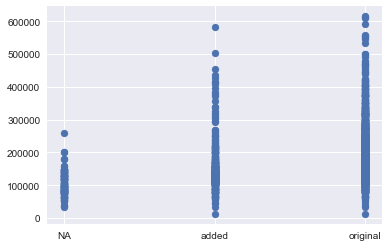

In [473]:
#interesting result
plt.scatter(data_df['Garage Extension'], data_df['SalePrice'])
plt.show()

In [474]:
## scaling the continuous features
data_df.loc[:, cont_var] = scale(data_df[cont_var], axis=0, copy=False)

In [475]:
## working on the discrete values
## we knoe that the year building will be deleted and replaced by our new features
### the number of romms stay as they are
### we still need to modify some variables to make them fit to modeling 
#discr_values = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 
#              'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
#              'Garage Cars', 'Mo Sold', 'Yr Sold']
data_df['Yr Sold'] = data_df['Yr Sold'] - 2006

In [476]:
### we keep the remaining discrete values as they make sense in a model the way they are
### like "each extra car that fits in the garage is priced +x dollars"
discr_values = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 
                'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 
                'Garage Cars']

In [477]:
## Our nom values will be one-hot encoded
nom_values = nom_values + ['Mo Sold']

In [478]:
### Our final set of variables
totVars = ord_values_cat + nom_values + discr_values + cont_var + ['LogSalePrice']
len(totVars)

74

In [479]:
print(totVars)

['Lot Shape_cat', 'Utilities_cat', 'Land Slope_cat', 'Overall Qual_cat', 'Overall Cond_cat', 'Exter Qual_cat', 'Exter Cond_cat', 'Bsmt Qual_cat', 'Bsmt Cond_cat', 'Bsmt Exposure_cat', 'BsmtFin Type 1_cat', 'BsmtFin Type 2_cat', 'Heating QC_cat', 'Electrical_cat', 'Kitchen Qual_cat', 'Functional_cat', 'Fireplace Qu_cat', 'Garage Finish_cat', 'Garage Qual_cat', 'Garage Cond_cat', 'Paved Drive_cat', 'Fence_cat', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Utilities', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Sale Type', 'Sale Condition', 'Garage Extension', 'Mo Sold', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF'

In [480]:
### one-hot encoding nominal values 
data_df_final = pd.get_dummies(data_df[totVars], columns=nom_values)

In [481]:
data_df_final.shape

(2406, 249)

In [482]:
for i in range(data_df_final.shape[1]):
    print(data_df_final.columns[i])

Lot Shape_cat
Utilities_cat
Land Slope_cat
Overall Qual_cat
Overall Cond_cat
Exter Qual_cat
Exter Cond_cat
Bsmt Qual_cat
Bsmt Cond_cat
Bsmt Exposure_cat
BsmtFin Type 1_cat
BsmtFin Type 2_cat
Heating QC_cat
Electrical_cat
Kitchen Qual_cat
Functional_cat
Fireplace Qu_cat
Garage Finish_cat
Garage Qual_cat
Garage Cond_cat
Paved Drive_cat
Fence_cat
Bsmt Full Bath
Bsmt Half Bath
Full Bath
Half Bath
Bedroom AbvGr
Kitchen AbvGr
TotRms AbvGrd
Fireplaces
Garage Cars
Lot Frontage
Lot Area
Mas Vnr Area
BsmtFin SF 1
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
1st Flr SF
2nd Flr SF
Low Qual Fin SF
Garage Area
Wood Deck SF
Enclosed Porch
Total Surface
Yrs since Re/A
Yrs since Blt
Yrs since Blt square
LogSalePrice
MS SubClass_20
MS SubClass_30
MS SubClass_40
MS SubClass_45
MS SubClass_50
MS SubClass_60
MS SubClass_70
MS SubClass_75
MS SubClass_80
MS SubClass_85
MS SubClass_90
MS SubClass_120
MS SubClass_150
MS SubClass_160
MS SubClass_180
MS SubClass_190
MS Zoning_A (agr)
MS Zoning_C (all)
MS Zoning_FV
MS 

# Models

### Simple Model

In [483]:
def rmse(y_tr, y_pred):
    return np.sqrt(mse(y_tr, y_pred))

In [484]:
def mae(y_tr, y_pred):
    return np.mean(np.abs(10**y_tr - 10**y_pred))

In [485]:
# Split intro train/test sets
# we fit our models on LogSalePrice so our RMSLE error metric is RMSE(LogSalePrice)
X_tr, X_te, y_tr, y_te = train_test_split(
    data_df_final.drop('LogSalePrice', axis=1), 
    data_df_final['LogSalePrice'], 
    train_size=0.5, test_size=0.5, random_state=0)

lr_feats = ['Total Surface',
            'Sale Condition_Abnorml', 'Sale Condition_AdjLand', 'Sale Condition_Alloca', 
            'Sale Condition_Family','Sale Condition_Normal', 'Sale Condition_Partial']
           

X_tr_lr = X_tr[lr_feats]
X_te_lr = X_te[lr_feats]

In [486]:
print('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)

Train set: (1203, 248) (1203,)
Test set: (1203, 248) (1203,)


In [487]:
print('Train set LR:', X_tr_lr.shape)
print('Test set LR:', X_te_lr.shape)

Train set LR: (1203, 7)
Test set LR: (1203, 7)


In [488]:
lr = LinearRegression()
lr.fit(X_tr_lr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [489]:
rmse_lr_tr = rmse(y_tr, lr.predict(X_tr_lr))
rmse_lr_te = rmse(y_te, lr.predict(X_te_lr))

mae_lr_tr = mae(y_tr, lr.predict(X_tr_lr))
mae_lr_te = mae(y_te, lr.predict(X_te_lr))

print('Linear regression - RMSE\ntrain: {:,.3f}\ntest: {:,.3f}'.format(
    rmse_lr_tr,
    rmse_lr_te
))

print('\nLinear regression - MAE\ntrain: {:,.3f}\ntest: {:,.3f}'.format(
    mae_lr_tr,
    mae_lr_te
))

Linear regression - RMSE
train: 0.104
test: 0.107

Linear regression - MAE
train: 31,598.394
test: 31,984.378


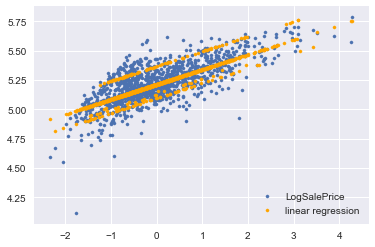

In [490]:
sns.set()
plt.scatter(X_te['Total Surface'], y_te, s=10)
plt.scatter(X_te['Total Surface'], lr.predict(X_te_lr), s=10, color='orange',  label='linear regression')
plt.legend()
plt.show()

### Baseline

In [491]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_tr, y_tr)
pred_baseline = dummy.predict(X_te)

mae_baseline = mae(y_te, pred_baseline)

print('Baseline - MAE: {:3F}'.format(mae_baseline))

Baseline - MAE: 53057.172337


### Intermediate

In [492]:
## we test a 15-feature intermediate model
int_feats = ['Total Surface', 
             'Sale Condition_Abnorml', 'Sale Condition_AdjLand', 'Sale Condition_Alloca', 'Sale Condition_Family','Sale Condition_Normal', 'Sale Condition_Partial', 
             'Functional_cat',
             'Garage Finish_cat',
             'Low Qual Fin SF',
             'Yrs since Blt',
             'Yrs since Blt square',
             'MS Zoning_A (agr)', 'MS Zoning_C (all)', 'MS Zoning_FV', 'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL', 'MS Zoning_RM',
             'Street_Grvl', 'Street_Pave', 
             'Alley_Grvl', 'Alley_NA', 'Alley_Pave',
             'Utilities_ELO', 'Utilities_NoSeWa', 'Utilities_NoSewr', 'Utilities_AllPub',
             'Bldg Type_1Fam', 'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'Bldg Type_TwnhsE',
             'Garage Extension_NA', 'Garage Extension_added', 'Garage Extension_original',
             'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 
             'Lot Area'
            ]

X_tr_int = X_tr[int_feats]
X_te_int = X_te[int_feats]

lr_int = LinearRegression()
lr_int.fit(X_tr_int, y_tr)

rmse_lr_int_tr = rmse(y_tr, lr_int.predict(X_tr_int))
rmse_lr_int_te = rmse(y_te, lr_int.predict(X_te_int))

mae_lr_int_tr = mae(y_tr, lr_int.predict(X_tr_int))
mae_lr_int_te = mae(y_te, lr_int.predict(X_te_int))

print('Linear regression - RMSE\ntrain: {:,.4e}\ntest: {:,.4e}'.format(
    rmse_lr_int_tr,
    rmse_lr_int_te
))

print('\nLinear regression - MAE\ntrain: {:,.4e}\ntest: {:,.4e}'.format(
    mae_lr_int_tr,
    mae_lr_int_te
))

Linear regression - RMSE
train: 7.5243e-02
test: 7.3382e-02

Linear regression - MAE
train: 2.2240e+04
test: 2.2012e+04


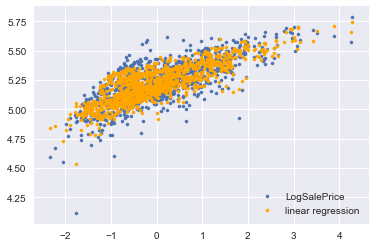

In [493]:
### getting there
plt.scatter(X_te['Total Surface'], y_te, s=10)
plt.scatter(X_te['Total Surface'], lr_int.predict(X_te_int), s=10, color='orange',  label='linear regression')
plt.legend()
plt.show()

### Intermediate Ridge

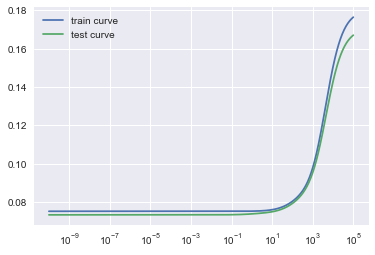

In [494]:
# Define a set of alpha values
alphas = np.logspace(-10, 5, num=1000)

# Save train/test scores
train_int_scores = []
test_int_scores = []

# Grid search
for alpha in alphas:
    # Ridge regression
    ridge = Ridge(alpha)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ridge.fit(X_tr_int, y_tr)
    
    # Train score
    y_pred = ridge.predict(X_tr_int)
    train_int_scores.append(rmse(y_tr, y_pred))
    
    # Test score
    y_pred = ridge.predict(X_te_int)
    test_int_scores.append(rmse(y_te, y_pred))
    
# Plot validation curves
plt.semilogx(alphas, train_int_scores, label='train curve')
plt.semilogx(alphas, test_int_scores, label='test curve')
plt.legend()
plt.show()

Once again we have test scores consistently smaller than the train scores, I can't figure out whether something's wrong in the code.

In [495]:
idx = np.argmin(test_int_scores)
best_alpha = alphas[idx]
print('Best alpha {:.4e}'.format(best_alpha))

# Print train/test scores
print('\nRidge regression - Intermediate Model - RMSE:\ntrain: {:,.4e}\ntest: {:,.4e}'.format(
    train_int_scores[idx],
    test_int_scores[idx]
))

Best alpha 1.0352e-10

Ridge regression - Intermediate Model - RMSE:
train: 7.5243e-02
test: 7.3382e-02



Ridge regression - Intermediate Model - MAE:
train: 2.2240e+04
test: 2.2012e+04


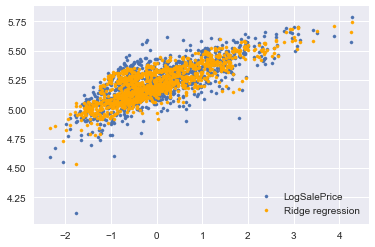

In [496]:
best_int_ridge = Ridge(best_alpha)
best_int_ridge.fit(X_tr_int, y_tr)

ridge_int_tr_pred = best_int_ridge.predict(X_tr_int)
ridge_int_te_pred = best_int_ridge.predict(X_te_int)

mae_ridge_tr_int = mae(ridge_int_tr_pred, y_tr)
mae_ridge_te_int = mae(ridge_int_te_pred, y_te)

print('\nRidge regression - Intermediate Model - MAE:\ntrain: {:,.4e}\ntest: {:,.4e}'.format(
    mae_ridge_tr_int,
    mae_ridge_te_int
))

plt.scatter(X_te['Total Surface'], y_te, s=10)
plt.scatter(X_te['Total Surface'],
            ridge_int_te_pred, s=10, color='orange',  label='Ridge regression')
plt.legend()
plt.show()

Ridge does not improve the model.

### The Complex model, aka "The Beast". 

In [530]:
lr_tot = LinearRegression()
lr_tot.fit(X_tr, y_tr)

rmse_lr_tot_tr = rmse(y_tr, lr_tot.predict(X_tr))
rmse_lr_tot_te = rmse(y_te, lr_tot.predict(X_te))

mae_lr_tot_tr = mae(y_tr, lr_tot.predict(X_tr))
mae_lr_tot_te = mae(y_te, lr_tot.predict(X_te))

print('Linear regression - RMSE\ntrain: {:,.4e}\ntest: {:,.4e}'.format(
    rmse_lr_tot_tr,
    rmse_lr_tot_te
))

print('\nLinear regression - MAE\ntrain: {:,.4e}\ntest: {:,.4e}'.format(
    mae_lr_tot_tr,
    mae_lr_tot_te
))

Linear regression - RMSE
train: 4.2876e-02
test: 1.2141e+07

Linear regression - MAE
train: 1.1419e+04
test: inf


C:\Users\jisnard.2015-JISNARD\Anaconda3\envs\exts-aml1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


We have a problem (whose name is probably "over-overfitting"). Let's try to Ridge it away. 

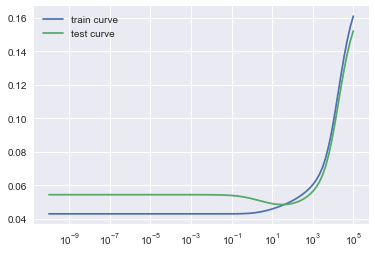

In [531]:
# Define a set of alpha values
alphas = np.logspace(-10, 5, num=100)

# Save train/test scores
train_tot_scores = []
test_tot_scores = []

# Grid search
for alpha in alphas:
    # Ridge regression
    ridge = Ridge(alpha)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ridge.fit(X_tr, y_tr)
    
    # Train score
    y_pred = ridge.predict(X_tr)
    train_tot_scores.append(rmse(y_tr, y_pred))
    
    # Test score
    y_pred = ridge.predict(X_te)
    test_tot_scores.append(rmse(y_te, y_pred))
    
# Plot validation curves
plt.semilogx(alphas, train_tot_scores, label='train curve')
plt.semilogx(alphas, test_tot_scores, label='test curve')
plt.legend()
plt.show()

In [532]:
idx_tot = np.argmin(test_tot_scores)
best_alpha = alphas[idx_tot]
print('Best alpha {:.4e}'.format(best_alpha))

# Print train/test scores
print('\nRidge regression - Intermediate Model - RMSE:\ntrain: {:,.4e}\ntest: {:,.4e}'.format(
    train_tot_scores[idx_tot],
    test_tot_scores[idx_tot]
))

Best alpha 3.2745e+01

Ridge regression - Intermediate Model - RMSE:
train: 4.8012e-02
test: 4.8429e-02



Ridge regression - Total Model - MAE:
train: 1.2484e+04
test: 1.2605e+04


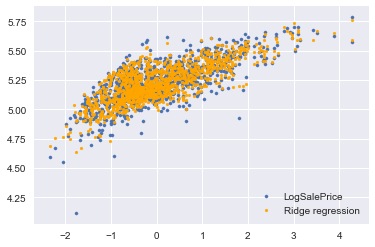

In [533]:
best_tot_ridge = Ridge(best_alpha)
best_tot_ridge.fit(X_tr, y_tr)

ridge_tot_tr_pred = best_tot_ridge.predict(X_tr)
ridge_tot_te_pred = best_tot_ridge.predict(X_te)

mae_ridge_tr_tot = mae(ridge_tot_tr_pred, y_tr)
mae_ridge_te_tot = mae(ridge_tot_te_pred, y_te)

print('\nRidge regression - Total Model - MAE:\ntrain: {:,.4e}\ntest: {:,.4e}'.format(
    mae_ridge_tr_tot,
    mae_ridge_te_tot
))

plt.scatter(X_te['Total Surface'], y_te, s=10)
plt.scatter(X_te['Total Surface'],
            ridge_tot_te_pred, s=8, color='orange',  label='Ridge regression')
plt.legend()
plt.show()

### Comparing

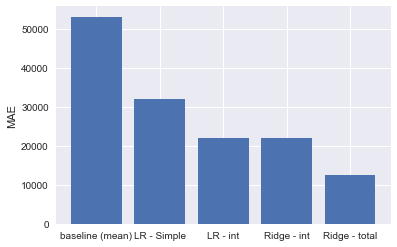

In [534]:
plt.bar([1, 2, 3, 4, 5], [mae_baseline, mae_lr_te, mae_lr_int_te, mae_ridge_te_int, mae_ridge_te_tot])
plt.xticks([1, 2, 3, 4, 5], ['baseline (mean)', 'LR - Simple', 'LR - int', 'Ridge - int', 'Ridge - total'])
plt.ylabel('MAE')
plt.show()

### toDollars()

In [535]:
price_test = pd.read_csv('house-prices-test.csv')

len([i for i in price_test['PID'] if i not in data_df_final.index])

500

*processing... sudden flash... understanding * 

NOOOOOOOOOOOooooooooooooooOOOoooooo

In [536]:
### *sigh*
### at least we can assume there are no missing obs issues like we had in the Garage and Basements variables
print(price_test.shape)
price_test.isnull().sum()[price_test.isnull().sum() > 0]

(500, 81)


Lot Frontage       70
Alley             465
Mas Vnr Type        3
Mas Vnr Area        3
Bsmt Qual           9
Bsmt Cond           9
Bsmt Exposure       9
BsmtFin Type 1      9
BsmtFin Type 2      9
Fireplace Qu      236
Garage Type        21
Garage Yr Blt      21
Garage Finish      21
Garage Qual        21
Garage Cond        21
Pool QC           499
Fence             417
Misc Feature      484
dtype: int64

In [537]:
### We, we need to modify the dataset so as to be able to make it fit in our model. 

### reformatting the house-test
### THE DUMB WAY ###
price_test.drop(['Misc Val', 'Misc Feature', 'Pool Area', 'Pool QC'], axis=1, inplace=True)
price_test.loc[price_test['Lot Frontage'].isnull(), 'Lot Frontage'] = 0
price_test.loc[price_test['Mas Vnr Type'].isnull(), 'Mas Vnr Type'] = 'None'
price_test.loc[price_test['Mas Vnr Area'].isnull(), 'Mas Vnr Area'] = 0

In [538]:
### as before, no info means absence of a feature
missing_values = price_test.isnull().sum()[price_test.isnull().sum() > 0].index
price_test.loc[:, missing_values] = price_test.loc[:, missing_values].fillna('NA')

In [539]:
price_test['Lot Shape'] = pd.Categorical(price_test['Lot Shape'], categories=['Reg', 'IR1', 'IR2', 'IR3'][::-1], 
                                      ordered=True)
price_test['Utilities'] = pd.Categorical(price_test['Utilities'], 
                                      categories=['AllPub', 'NoSewr', 'NoSeWa', 'ELO'][::-1], ordered=True)
price_test['Land Slope'] = pd.Categorical(price_test['Land Slope'], 
                                       categories=['Gtl', 'Mod', 'Sev'][::-1],ordered=True)
price_test['Overall Qual'] = pd.Categorical(price_test['Overall Qual'], 
                                            categories = range(1, 11),
                                            ordered=True)
price_test['Overall Cond'] = pd.Categorical(price_test['Overall Cond'],
                                            categories = range(1, 11),
                                            ordered=True)
price_test['Exter Qual'] = pd.Categorical(price_test['Exter Qual'], 
                                       categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'][::-1], 
                                       ordered=True)
price_test['Exter Cond'] = pd.Categorical(price_test['Exter Cond'], 
                                       categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'][::-1], 
                                       ordered=True)
price_test['Bsmt Qual'] = pd.Categorical(price_test['Bsmt Qual'], 
                                      categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                      ordered=True)
price_test['Bsmt Cond'] = pd.Categorical(price_test['Bsmt Cond'], 
                                      categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                      ordered=True)
price_test['Bsmt Exposure'] = pd.Categorical(price_test['Bsmt Exposure'], 
                                          categories=['Gd', 'Av', 'Mn', 'No', 'NA'][::-1], ordered=True)
price_test['BsmtFin Type 1'] = pd.Categorical(price_test['BsmtFin Type 1'], 
                                           categories=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'][::-1], 
                                           ordered=True)
price_test['BsmtFin Type 2'] = pd.Categorical(price_test['BsmtFin Type 2'], 
                                           categories=['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'][::-1], 
                                           ordered=True)
price_test['Heating QC'] = pd.Categorical(price_test['Heating QC'], 
                                       categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'][::-1], 
                                       ordered=True)
price_test['Electrical'] = pd.Categorical(price_test['Electrical'], 
                                       categories=['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'][::-1], 
                                       ordered=True)
price_test['Kitchen Qual'] = pd.Categorical(price_test['Kitchen Qual'], 
                                         categories=['Ex', 'Gd', 'TA', 'Fa', 'Po'][::-1], 
                                         ordered=True)
price_test['Functional'] = pd.Categorical(price_test['Functional'], 
                                       categories=['Typ', 'Min1', 'Min2', 'Mod', 
                                                   'Maj1', 'Maj2', 'Sev', 'Sal'][::-1], 
                                       ordered=True)
price_test['Fireplace Qu'] = pd.Categorical(price_test['Fireplace Qu'], 
                                         categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                       ordered=True)
price_test['Garage Finish'] = pd.Categorical(price_test['Garage Finish'], 
                                          categories=['Fin', 'RFn', 'Unf', 'NA'][::-1], 
                                       ordered=True)
price_test['Garage Qual'] = pd.Categorical(price_test['Garage Qual'], 
                                        categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                       ordered=True)
price_test['Garage Cond'] = pd.Categorical(price_test['Garage Cond'], 
                                        categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'][::-1], 
                                       ordered=True)
price_test['Paved Drive'] = pd.Categorical(price_test['Paved Drive'], 
                                        categories=['Y', 'P', 'N'][::-1], 
                                       ordered=True)
price_test['Fence'] = pd.Categorical(price_test['Fence'], 
                                  categories=['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'][::-1], 
                                       ordered=True)

In [540]:
for i in ord_values:
    price_test[i + '_cat'] = price_test[i].cat.codes

price_test[ord_values_cat].head()

,Lot Shape_cat,Utilities_cat,Land Slope_cat,Overall Qual_cat,Overall Cond_cat,Exter Qual_cat,Exter Cond_cat,Bsmt Qual_cat,Bsmt Cond_cat,Bsmt Exposure_cat,...,Heating QC_cat,Electrical_cat,Kitchen Qual_cat,Functional_cat,Fireplace Qu_cat,Garage Finish_cat,Garage Qual_cat,Garage Cond_cat,Paved Drive_cat,Fence_cat
0,2,3,1,5,6,2,2,3,3,2,...,2,4,2,7,4,1,3,2,2,0
1,3,3,1,4,6,2,3,3,3,1,...,4,4,2,7,0,2,3,3,2,0
2,2,3,2,7,4,3,2,4,3,2,...,4,4,4,7,4,3,3,3,2,0
3,3,3,2,4,6,2,2,3,3,1,...,4,4,2,7,0,2,3,3,2,1
4,3,3,1,3,6,2,2,3,3,2,...,3,4,2,7,0,2,3,3,0,0


In [541]:
### Total finished surface
price_test['Total Surface'] = price_test['1st Flr SF'] + price_test['2nd Flr SF'] + price_test['BsmtFin SF 1'] + price_test['BsmtFin SF 2']

### Elapsed years since the last work on the house
price_test['Yrs since Re/A'] = price_test['Yr Sold'] - price_test['Year Remod/Add']

### Elapsed years since building
price_test['Yrs since Blt'] = price_test['Yr Sold'] - price_test['Year Built']

### Using age square as a feature is a common practice, we try it out
price_test['Yrs since Blt square'] = price_test['Yrs since Blt'] **2

In [542]:
idx_garagenull = price_test['Garage Yr Blt'] == 'NA'
price_test.loc[idx_garagenull, 'Garage Yr Blt'] = 0

In [543]:
##### grmblblblbl

cont_var = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
           'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 
           'Low Qual Fin SF', 'Garage Area', 'Wood Deck SF', 'Enclosed Porch',
           'Total Surface', 'Yrs since Re/A', 'Yrs since Blt','Yrs since Blt square']

### listing ordinal values
ord_values = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 
              'Exter Cond', 'Bsmt Qual',
             'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 
             'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond',
             'Paved Drive', 'Fence']

### listing nominal values 
nom_values = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Utilities', 'Lot Config',
             'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 
              'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 
             'Heating', 'Central Air', 'Garage Type', 'Sale Type', 'Sale Condition','Garage Extension']

### listing discrete values
discr_values = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 
               'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
               'Garage Cars', 'Mo Sold', 'Yr Sold']

In [544]:
for var in cont_var:
    price_test[var] = pd.to_numeric(price_test[var])

In [545]:
for var in discr_values:
    price_test[var] = pd.to_numeric(price_test[var])

In [546]:
garage_yr = []
for i in price_test.index:
    if price_test.loc[i, 'Garage Yr Blt'] == 0:
        garage_yr = garage_yr + ['NA']
    elif ((price_test.loc[i, 'Garage Yr Blt'] == price_test.loc[i, 'Year Built']) | 
          (price_test.loc[i, 'Garage Yr Blt'] < price_test.loc[i, 'Year Built'])):
        garage_yr = garage_yr + ['original']
    else:
        garage_yr = garage_yr + ['added']

In [547]:
price_test['Garage Extension'] = garage_yr

In [548]:
price_test.loc[:, cont_var] = scale(price_test[cont_var], axis=0, copy=False)
price_test['Yr Sold'] = price_test['Yr Sold'] - 2006
discr_values = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 
                'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 
                'Garage Cars']

In [549]:
nom_values = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Utilities', 'Lot Config',
             'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 
              'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 
             'Heating', 'Central Air', 'Garage Type', 'Sale Type', 'Sale Condition','Garage Extension',
              'Mo Sold']

In [550]:
### looks consistent with what it should be
totVars = ord_values_cat + nom_values + discr_values + cont_var
len(totVars)

73

In [551]:
price_test.set_index('PID', inplace=True)
price_test.drop('Order', axis = 1, inplace=True)

price_test_final = pd.get_dummies(price_test[totVars], columns=nom_values)

In [552]:
## missing values
price_test_final.shape

(500, 222)

### Reindexing the columns 

In [553]:
price_test_final = price_test_final.reindex(columns = X_tr.columns, 
                                           fill_value=0)

In [554]:
(price_test_final.columns == X_tr.columns).sum()

248

In [555]:
missing = [i for i in data_df_final.columns if i not in price_test_final.columns]
missing

['LogSalePrice']

This is consistent with the expected result. 

In [556]:
### So far, we're good.
price_test_final.shape

(500, 248)

In [557]:
# Convert predictions to dollars
predictions = 10**best_tot_ridge.predict(price_test_final)

# Create DataFrame for predictions
predictions_df = pd.DataFrame.from_items([
    ('PID', price_test_final.index),
    ('SalePrice', predictions)
])


In [558]:
data_df.SalePrice.describe()

count      2406.000000
mean     178958.687864
std       77160.739751
min       12789.000000
25%      128962.500000
50%      160000.000000
75%      212850.000000
max      615000.000000
Name: SalePrice, dtype: float64

In [559]:
predictions_df.SalePrice.describe()

count    5.000000e+02
mean     1.805651e+05
std      8.480214e+04
min      4.908875e+04
25%      1.285026e+05
50%      1.582494e+05
75%      2.096435e+05
max      1.013021e+06
Name: SalePrice, dtype: float64

Our predictions approximate the original distribution. 

In [560]:
predictions_int = 10**best_int_ridge.predict(price_test_final[int_feats])

# Create DataFrame for predictions
predictions_int_df = pd.DataFrame.from_items([
    ('PID', price_test_final.index),
    ('SalePrice', predictions_int)
])

In [561]:
predictions_int_df.SalePrice.describe()

count    5.000000e+02
mean     1.790006e+05
std      8.621425e+04
min      5.027804e+04
25%      1.260442e+05
50%      1.620691e+05
75%      2.141458e+05
max      1.244495e+06
Name: SalePrice, dtype: float64

The max is a bit off.  Would be worth investigating in another project. 

In [562]:
predictions_df.to_csv('house-prices-pred.csv', index=False, float_format='%.0f')
predictions_int_df.to_csv('house-prices-pred-int.csv', index=False, float_format='%.0f')